## 1. Preparing our dataset
<p><em>These recommendations are so on point! How does this playlist know me so well?</em></p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/iphone_music.jpg" alt="Project Image Record" width="600px"></p>
<p>Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.</p>
<p>For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, such as decision trees and logistic regression.</p>
<p>To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as <code>danceability</code> and <code>acousticness</code> on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.</p>
<p>Let's start by creating two pandas <code>DataFrames</code> out of these files that we can merge so we have features and labels (often also referred to as <code>X</code> and <code>y</code>) for the classification later on.</p>

### Project Description

Using a dataset comprised of songs of two music genres (Hip-Hop and Rock), you will train a classifier to distinguish between the two genres based only on track information derived from Echonest (now part of Spotify). You will first make use of pandas and seaborn packages in Python for subsetting the data, aggregating information, and creating plots when exploring the data for obvious trends or factors you should be aware of when doing machine learning. Next, you will use the scikit-learn package to predict whether you can correctly classify a song's genre based on features such as danceability, energy, acousticness, tempo, etc. You will go over implementations of common algorithms such as PCA, logistic regression, decision trees, and so forth.

Link to dataset: http://millionsongdataset.com/tasteprofile/



In this project, I will apply what I have learned in Supervised Learning with scikit-learn, plus data preprocessing, dimensionality reduction, and machine learning using the scikit-learn package. 

In [110]:
# IMPORT ALL NECCESSARY LIBRARIES
import pandas as pd
import numpy as np
import warnings
from pprint import pprint                                  # Import parameter print
import matplotlib.pyplot as plt                            # Import plotting module
from scipy.stats import randint                            # Import randint
from sklearn.linear_model import LogisticRegression        # Import Logistic Regression
from sklearn.decomposition import PCA                      # Import PCA class
from sklearn.preprocessing import StandardScaler           # Import the Standard Scaler
from sklearn.model_selection import train_test_split       # Import train_test_split function
from sklearn.tree import DecisionTreeClassifier            # Import Decision tree classifier
from sklearn.metrics import classification_report          # Import Classification Report
from sklearn.model_selection import RandomizedSearchCV     # Import Randomized Search CV
from sklearn.model_selection import KFold, cross_val_score # Import KFold, Cross Validation Score 
from sklearn.ensemble import RandomForestClassifier        # Import random forest
from sklearn.model_selection import GridSearchCV           # Import Grid Search CV


# ignore all harmless waring to keep the notebook clean
warnings.filterwarnings('ignore')
# This is just to make plots appear in the notebook
%matplotlib inline

# Step 1: Load, Clean and Prepare the Data

##### Using the pandas read_csv() function, read in the file with the track metadata (datasets/fma-rock-vs-hiphop.csv) and name the DataFrame tracks.

In [111]:
# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')
# Quick look at the head of data
print(tracks.head())

   track_id  bit_rate  comments        composer         date_created  \
0       135    256000         1             NaN  2008-11-26 01:43:26   
1       136    256000         1             NaN  2008-11-26 01:43:35   
2       151    192000         0             NaN  2008-11-26 01:44:55   
3       152    192000         0             NaN  2008-11-26 01:44:58   
4       153    256000         0  Arc and Sender  2008-11-26 01:45:00   

         date_recorded  duration  favorites genre_top    genres  ...  \
0  2008-11-26 00:00:00       837          0      Rock  [45, 58]  ...   
1  2008-11-26 00:00:00       509          0      Rock  [45, 58]  ...   
2                  NaN       192          0      Rock      [25]  ...   
3                  NaN       193          0      Rock      [25]  ...   
4  2008-11-26 00:00:00       405          5      Rock      [26]  ...   

  information interest  language_code  \
0         NaN     2484             en   
1         NaN     1948             en   
2         N

##### Using the pandas read_json() function, read in the JSON file with the track acoustic metrics (datasets/echonest-metrics.json) and name the DataFrame echonest_metrics. Set the precise_float argument to True when reading in data.

In [112]:
# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json', precise_float = True)
# Quick look at the head of data
echonest_metrics.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
10,145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,120.790,0.650452
100,341,0.977282,0.468808,0.134975,0.687700,0.105381,0.073124,119.646,0.430707
1000,3457,0.081256,0.897197,0.367886,0.104474,0.085845,0.041271,100.744,0.749293


In [113]:
echonest_metrics.describe()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
count,13129.000000,1.312900e+04,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000
mean,34031.058268,5.246876e-01,0.487290,0.537516,0.640536,0.187804,0.099174,123.080061,0.439761
std,28950.422182,3.837186e-01,0.190148,0.278049,0.361430,0.158051,0.137381,35.015137,0.276028
min,2.000000,9.035000e-07,0.051307,0.000020,0.000000,0.025297,0.022324,12.753000,0.000010
25%,12986.000000,1.037726e-01,0.344759,0.321300,0.323466,0.101406,0.036932,95.967000,0.197321
50%,28097.000000,5.739848e-01,0.485635,0.549113,0.838134,0.119002,0.049019,120.057000,0.417743
75%,45021.000000,9.207270e-01,0.629094,0.776254,0.918244,0.211041,0.085452,145.318000,0.665575
max,124911.000000,9.957965e-01,0.968645,0.999964,0.998016,0.980330,0.966177,251.072000,0.999990


In [114]:
# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['title','track_id', 'genre_top']], on='track_id')
# Quick look at the head of data
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,title,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Food,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Electric Ave,Hip-Hop
2,341,0.977282,0.468808,0.134975,0.687700,0.105381,0.073124,119.646,0.430707,Count Dracula's castle,Rock
3,46204,0.953349,0.498525,0.552503,0.924391,0.684914,0.028885,78.958,0.430448,Heavy Deeds (live at SXSW),Rock
4,46205,0.613229,0.500320,0.487992,0.936811,0.637750,0.030327,112.667,0.824749,Crete (live at SXSW),Rock


In [115]:
print(tracks.keys())

Index(['track_id', 'bit_rate', 'comments', 'composer', 'date_created',
       'date_recorded', 'duration', 'favorites', 'genre_top', 'genres',
       'genres_all', 'information', 'interest', 'language_code', 'license',
       'listens', 'lyricist', 'number', 'publisher', 'tags', 'title'],
      dtype='object')


In [116]:
print(echonest_metrics.keys())

Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')


In [117]:
print(echo_tracks.keys())

Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence',
       'title', 'genre_top'],
      dtype='object')


In [118]:
# Inspect echo_tracks
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 11 columns):
track_id            4802 non-null int64
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
valence             4802 non-null float64
title               4802 non-null object
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(2)
memory usage: 450.2+ KB


### 'title' and 'genre_top' are object data type. Later, we will drop them when we define our features and assign genre_top as our labels.

## Step 2. PAIRWISE RELATIONSHIPS BETWEEN CONTINUOS VARIABLES
#### Explore correlations in our dataset using pandas corr function. Visually inspect the correlation table generated from DataFrame.corr() for any strong correlations.
<p>We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:</p>
<ul>
<li>To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).</li>
<li>When our datasets are very large, using fewer features can drastically speed up our computation time.</li>
</ul>
<p>To get a sense of whether there are any strongly correlated features in our data, we will use built-in functions in the <code>pandas</code> package.</p>

#### Blue means positive, purple means negative. The stronger the color, the larger the correlation magnitude

In [119]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1,-0.372282,0.0494541,0.140703,-0.275623,0.0482307,-0.0269951,-0.0253918,0.0100698
acousticness,-0.372282,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.0138406
danceability,0.0494541,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.0386027
instrumentalness,-0.275623,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.219967
liveness,0.0482307,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,-0.0450931
speechiness,-0.0269951,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,0.149894
tempo,-0.0253918,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,0.0522212
valence,0.0100698,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,1


## Step 3. Normalizing the feature data

using the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our data. There are a few methods to do this, but a common way is through <em>standardization</em>, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).

In [120]:
# Define our features 
features = echo_tracks.drop(['title', 'track_id', 'genre_top'], axis=1)

# Define our labels
labels = echo_tracks['genre_top']

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

## Step 4. Train a decision tree to classify genre
<p> We first need to split our dataset into 'train' and 'test' subsets, where the 'train' subset will be used to train our model while the 'test' dataset allows for model performance validation.</p>
<p>Here, we will be using a simple algorithm known as a decision tree. Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to ultimately classify a data point into one of two or more categories. In addition to being easy to both use and interpret, decision trees allow us to visualize the 'logic flowchart' that the model generates from the training data.</p>
<p>Here is an example of a decision tree that demonstrates the process by which an input image (in this case, of a shape) might be classified based on the number of sides it has and whether it is rotated.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/simple_decision_tree.png" alt="Decision Tree Flow Chart Example" width="350px"></p>

In [121]:
# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(scaled_train_features, labels, random_state=10)

# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

## Step 5. Using Logistic Regression
<p>Although our tree's performance is decent, it's a bad idea to immediately assume that it's therefore the perfect tool for this job -- there's always the possibility of other models that will perform even better! It's always a worthwhile idea to at least test a few other algorithms and find the one that's best for our data.</p>
<p>Sometimes simplest is best, and so we will start by applying <strong>logistic regression</strong>. Logistic regression makes use of what's called the logistic function to calculate the odds that a given data point belongs to a given class. Once we have both models, we can compare them on a few performance metrics, such as false positive and false negative rate (or how many points are inaccurately classified). </p>

In [122]:
# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state =10)
logreg.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_logit = logreg.predict(test_features)

## Step 6. Using Random Forest
<p>Random Forest is an Ensemble method which is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default)</p>

In [123]:
# Train the data
rfc = RandomForestClassifier(random_state =10)
rfc.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_rfc = rfc.predict(test_features)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

## Step 7. Now, we compare the models to see which one is the best

In [125]:
# Compare the models
print(      "Decision Tree: \n", classification_report(pred_labels_tree, test_labels))
print("Logistic Regression: \n", classification_report(pred_labels_logit, test_labels))
print(      "Random Forest: \n", classification_report(pred_labels_rfc, test_labels))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.71      0.73       239
        Rock       0.93      0.94      0.93       962

   micro avg       0.89      0.89      0.89      1201
   macro avg       0.84      0.82      0.83      1201
weighted avg       0.89      0.89      0.89      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.63      0.78      0.70       185
        Rock       0.96      0.92      0.94      1016

   micro avg       0.90      0.90      0.90      1201
   macro avg       0.79      0.85      0.82      1201
weighted avg       0.91      0.90      0.90      1201

Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.78      0.81      0.79       221
        Rock       0.96      0.95      0.95       980

   micro avg       0.92      0.92      0.92      1201
   macro avg       0.87      0.88      0.87      1201
weighted avg     

## Step 8. Balance our data for greater performance
<p>Both our models do similarly well, boasting an average precision of 87% each. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs. </p>
<p>Why might this be the case? Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.</p>
<p>To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in <em>sample size</em> of our data points when weighting our classes here, and not relative importance of each class. </p>

In [126]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only  = echo_tracks[echo_tracks['genre_top'] =='Hip-Hop']
rock_only = echo_tracks[echo_tracks['genre_top'] =='Rock']

In [127]:
echo_tracks['genre_top'].value_counts()

Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64

In [128]:
echo_tracks['genre_top'].value_counts(normalize=True)

Rock       0.810496
Hip-Hop    0.189504
Name: genre_top, dtype: float64

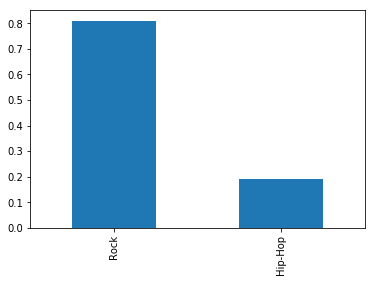

In [129]:
echo_tracks['genre_top'].value_counts(normalize =True).plot(kind ='bar')

In [130]:
# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(len(hop_only), random_state =10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['title', 'genre_top', 'track_id'], axis=1) 
labels   = rock_hop_bal['genre_top']

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(scaled_train_features, labels, random_state =10)

## Step 9. Does balancing our dataset improve model bias?
<p>We've now balanced our dataset, but in doing so, we've removed a lot of data points that might have been crucial to training our models. Let's test to see if balancing our data improves model bias towards the "Rock" classification while retaining overall classification performance. </p>
<p>Note that we have already reduced the size of our dataset and will go forward without applying any dimensionality reduction. In practice, we would consider dimensionality reduction more rigorously when dealing with vastly large datasets and when computation times become prohibitively large.</p>

In [131]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state =10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state =10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Train our random forest on the balanced data
rfc = RandomForestClassifier(random_state =10)
rfc.fit(train_features, train_labels)
pred_labels_rfc = rfc.predict(test_features)

# Compare the models
print(      "Decision Tree: \n", classification_report(pred_labels_tree, test_labels))
print("Logistic Regression: \n", classification_report(pred_labels_logit, test_labels))
print(      "Random Forest: \n", classification_report(pred_labels_rfc, test_labels))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.86      0.85      0.85       232
        Rock       0.84      0.85      0.85       223

   micro avg       0.85      0.85      0.85       455
   macro avg       0.85      0.85      0.85       455
weighted avg       0.85      0.85      0.85       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.85      0.86      0.86       227
        Rock       0.86      0.85      0.86       228

   micro avg       0.86      0.86      0.86       455
   macro avg       0.86      0.86      0.86       455
weighted avg       0.86      0.86      0.86       455

Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.92      0.89      0.90       237
        Rock       0.88      0.91      0.90       218

   micro avg       0.90      0.90      0.90       455
   macro avg       0.90      0.90      0.90       455
weighted avg     

## Step 10. Using cross-validation to evaluate our models
<p>Success! Balancing our data has removed bias towards the more prevalent class. To get a good sense of how well our models are actually performing, we can apply what's called <strong>cross-validation</strong> (CV). This step allows us to compare models in a more rigorous fashion.</p>
<p>Since the way our data is split into train and test sets can impact model performance, CV attempts to split the data multiple ways and test the model on each of the splits. Although there are many different CV methods, all with their own advantages and disadvantages, we will use what's known as <strong>K-fold</strong> CV here. K-fold first splits the data into K different, equally sized subsets. Then, it iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, we can then aggregate the results from each fold for a final model performance score.</p>

In [132]:
# Set up our K-fold cross-validation
kf = KFold(10, random_state=10)

tree        = DecisionTreeClassifier(random_state=10)
logreg      = LogisticRegression(random_state=10)
randforest  = RandomForestClassifier(random_state =10)

# Train our models using KFold cv
tree_score  = cross_val_score(tree,features, labels, cv=kf)
logit_score = cross_val_score(logreg,features, labels, cv=kf)
randf_score = cross_val_score(randforest,features, labels,cv=kf)

# Print the mean of each array of scores
print("Decision Tree       :", np.mean(tree_score),"\n",
      "Logistic Regression :", np.mean(logit_score),"\n",
      "Random Forest       :", np.mean(randf_score))

 Decision Tree      : 0.804945054945055 
 Logistic Regression: 0.8087912087912088 
 Random Forest      : 0.8637362637362639


### We see that Random Forest seems to give the best score for our classification problem. Now, we will use Hyperparameter to fine tuning the algorithm to find the best parameters for the model

## Step 11. Use Hyperparameter to further tuning the model

In [133]:
# Examine the default parameters of Random Forest Classifier algorithm
randforest  = RandomForestClassifier(random_state=10)

print('Default parameters of Random Forest Classifier:\n')
pprint(randforest.get_params())

Default parameters of Random Forest Classifier:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}


In [106]:
# Create the parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [None, 80, 90, 100, 110],
    'max_features': [None, 2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
    'n_estimators': [100, 200, 300, 400, 500, 1000]
}

# Use grid search
grid_search = GridSearchCV(estimator = randforest, param_grid = param_grid, cv = 3, n_jobs = -1, return_train_score=True)

In [70]:
# Fit the grid search to the data
grid_search.fit(scaled_train_features, labels);

In [71]:
# print the best params
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

## Step 12. Compare the best Random Forest model with other models

In [72]:
# Review the result of the best estimator
best_estimator = grid_search.best_estimator_
randf_score = cross_val_score(best_estimator, scaled_train_features, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree       :", np.mean(tree_score),"\n",
      "Logistic Regression :", np.mean(logit_score),"\n",
      "Random Forest       :", np.mean(randf_score))

 Decision Tree      : 0.7241758241758242 
 Logistic Regression: 0.7752747252747252 
 Random Forest      : 0.8104395604395604


### Random Forest is still the best model, after hyperparameter tuning the score was improved .........

## Step 13. Principal Component Analysis on our scaled data
<p>Principal component analysis (PCA) simplifies the complexity in high-dimensional data while retaining trends and patterns. By reducing the dimensionality of the variable space by representing it with a few orthogonal (uncorrelated) variables that capture most of its variability. It does this by transforming the data into fewer dimensions, which act as summaries of features. However, PCA will not always find the important patterns.</p>
<p>Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use <strong>scree-plots</strong> and <strong>cumulative explained ratio plots</strong> to find the number of components to use in further analyses.</p>
<p>Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.</p>

[0.25388002 0.16910233 0.14827773 0.13032824 0.09850611 0.08681495
 0.06429509 0.04879553]
8
[0.25388002 0.16910233 0.14827773 0.13032824 0.09850611 0.08681495
 0.06429509 0.04879553]


Text(0.5, 0, 'Principal Component #')

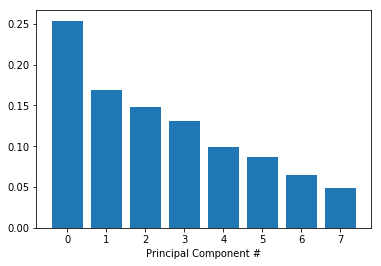

In [134]:
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
print(pca.explained_variance_ratio_)
print(pca.n_components_)
print(exp_variance)

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

## Step 14. Further visualization of PCA
<p>Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method. </p>
<p>But all is not lost! Instead, we can also look at the <strong>cumulative explained variance plot</strong> to determine how many features are required to explain, say, about 90% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by 'rules of thumb'). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.</p>

[0.25388002 0.42298235 0.57126008 0.70158831 0.80009442 0.88690937
 0.95120447 1.        ]


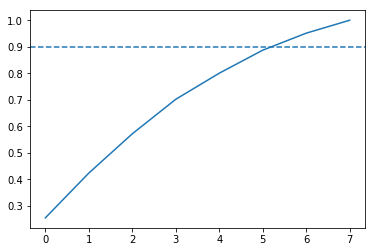

In [135]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)
print(cum_exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(range(pca.n_components_), cum_exp_variance)
ax.axhline(y =0.9, linestyle ='--')
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state =10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

## Step 15. After PCA - Train a Decision Tree to classify genre
Now we can use the lower dimensional PCA projection of the data to classify songs into genres.

In [136]:
# Split our data
train_features, test_features, train_labels, test_labels =train_test_split(pca_projection,labels,random_state=10)

# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

## Step 16. After PCA - Using Logistic Regression

In [137]:
# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_logit = logreg.predict(test_features)

## Step 17. After PCA - Using Random Forest

In [138]:
# Using Random Forest
rfc = RandomForestClassifier(random_state=10)
rfc.fit(train_features, train_labels)
pred_labels_rfc = rfc.predict(test_features)

# Compare the models
print(      "Decision Tree: \n", classification_report(pred_labels_tree, test_labels))
print("Logistic Regression: \n", classification_report(pred_labels_logit, test_labels))
print(      "Random Forest: \n", classification_report(pred_labels_rfc, test_labels))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.77      0.77       229
        Rock       0.76      0.76      0.76       226

   micro avg       0.76      0.76      0.76       455
   macro avg       0.76      0.76      0.76       455
weighted avg       0.76      0.76      0.76       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.83      0.82      0.82       234
        Rock       0.81      0.82      0.82       221

   micro avg       0.82      0.82      0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455

Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.87      0.82      0.84       243
        Rock       0.80      0.85      0.83       212

   micro avg       0.84      0.84      0.84       455
   macro avg       0.83      0.84      0.83       455
weighted avg     

## Step 18. After PCA - Balance our data for greater performance

In [139]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only  = echo_tracks[echo_tracks['genre_top'] =='Hip-Hop']
rock_only = echo_tracks[echo_tracks['genre_top'] =='Rock']

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(len(hop_only), random_state =10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features       = rock_hop_bal.drop(['title', 'genre_top', 'track_id'], axis=1) 
labels         = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, \
test_labels = train_test_split(pca_projection, labels, random_state =10)

## Step 19. After PCA - Compare all three methods

In [140]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state =10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state =10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Train our random forest on the balanced data
rfc = RandomForestClassifier(random_state=10)
rfc.fit(train_features, train_labels)
pred_labels_rfc = rfc.predict(test_features)

# Compare the models
print(      "Decision Tree: \n", classification_report(pred_labels_tree, test_labels))
print("Logistic Regression: \n", classification_report(pred_labels_logit, test_labels))
print(      "Random Forest: \n", classification_report(pred_labels_rfc, test_labels))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.77      0.77       229
        Rock       0.76      0.76      0.76       226

   micro avg       0.76      0.76      0.76       455
   macro avg       0.76      0.76      0.76       455
weighted avg       0.76      0.76      0.76       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.83      0.82      0.82       234
        Rock       0.81      0.82      0.82       221

   micro avg       0.82      0.82      0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455

Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.87      0.82      0.84       243
        Rock       0.80      0.85      0.83       212

   micro avg       0.84      0.84      0.84       455
   macro avg       0.83      0.84      0.83       455
weighted avg     

## Step 20. After PCA - Using cross-validation to evaluate our models

In [141]:
# Set up our K-fold cross-validation
kf = KFold(10, random_state=10)

tree        = DecisionTreeClassifier(random_state=10)
logreg      = LogisticRegression(random_state=10)
randforest  = RandomForestClassifier(random_state=10)

# Train our models using KFold cv
tree_score  = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)
randf_score = cross_val_score(randforest, pca_projection,labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree       :", np.mean(tree_score),"\n",
      "Logistic Regression :", np.mean(logit_score),"\n",
      "Random Forest       :", np.mean(randf_score))

 Decision Tree      : 0.7241758241758242 
 Logistic Regression: 0.7752747252747252 
 Random Forest      : 0.7862637362637361


### We see that Random Forest seems to give the best score for our classification problem. Now, we will use Hyperparameter to fine tuning the algorithm to find the best parameters for the model

## Step 21. Use Hyperparameter to further tuning the model

In [68]:
# import parameter print
from pprint import pprint

# Examine the default parameters of Random Forest Classifier algorithm
randforest  = RandomForestClassifier(random_state=10)

print('Default parameters of Random Forest Classifier:\n')
pprint(randforest.get_params())

Default parameters of Random Forest Classifier:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}


In [69]:
# Use GridSearchCV
from sklearn.model_selection import GridSearchCV

# Create the parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [None, 80, 90, 100, 110],
    'max_features': [None, 2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
    'n_estimators': [100, 200, 300, 400, 500, 1000]
}

# Use grid search
grid_search = GridSearchCV(estimator = randforest, param_grid = param_grid, cv = 3, n_jobs = -1, return_train_score=True)

In [70]:
# Fit the grid search to the data
grid_search.fit(pca_projection, labels);

In [71]:
# print the best params
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

## Step 22. Compare the models

In [72]:
# Review the result of the best estimator
best_estimator = grid_search.best_estimator_
randf_score = cross_val_score(best_estimator, pca_projection, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree       :", np.mean(tree_score),"\n",
      "Logistic Regression :", np.mean(logit_score),"\n",
      "Random Forest       :", np.mean(randf_score))

 Decision Tree      : 0.7241758241758242 
 Logistic Regression: 0.7752747252747252 
 Random Forest      : 0.8104395604395604


### Now, we see that by using the GridSearchCV we can find the best params to fine tune the Randon Forest and we can improve the score a little bit from 0.78 to 0.81


## Conclusion

With Decision Tree and Logistic Regression we can classify songs into different genres based on it features with accuracy about 75%.
With Random Forest we can achieve a little better result with accuracy about 85%.